In [165]:
import nltk.corpus 
from nltk.corpus import gutenberg
from nltk.corpus import brown
from nltk.text import Text
from nltk.corpus import stopwords
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import jaccard_score
import numpy as np
import re
import json
import string

In [170]:
filenames =  nltk.corpus.gutenberg.fileids()
with open("/Users/vedantsingh/nltk_data/corpora/gutenberg/result.txt", "w") as f:
    for filename in filenames:
        f.write(nltk.corpus.gutenberg.raw(filename))

In [171]:
moby = Text(nltk.corpus.gutenberg.words('result.txt'))
def find_corcordance_word(word, dict):
    stop_words = stopwords.words('english')
    t = moby.concordance_list(word, lines=15)
    sentences = []
    for text in t:
        sentence = text.left + [word] + text.right
        x = [word.strip(string.punctuation) for word in sentence
                                     if  re.search('[A-Za-z]', word) and word.lower() not in stop_words]
        x = [word.lower() for word in x]
        sentences.append(x)
    dict[word] = list(sentences)

In [178]:
input_dict = {}
animals = ['dog', 'cat', 'mouse', 'cow','buffalo','tiger', 'lion', 'deer', 'goat', 'monkey']
birds = ['pigeon', 'crow','sparrow', 'owl', 'goose','duck','eagle','vulture','chicken','dove']
for animal in animals:
    find_corcordance_word(animal, input_dict)
for bird in birds:
    find_corcordance_word(bird, input_dict)
print(input_dict)


{'dog': [['builders', 'association', 'philadelphia', 'behalf', 'association', 'members', 'operate', 'apartment', 'houses', 'proposal', 'raise', 'dog', 'license', 'fees', 'drew', 'objection', 'councilwoman', 'virginia', 'knauer', 'formerly', 'raised', 'pedigreed', 'dogs', 'ordinance'], ['ordinance', 'would', 'increase', 'fees', 'males', 'females', 'flat', 'dog', 'commissioner', 'replies', 'mrs', 'knauer', 'said', 'think', 'dog', 'owners', 'penalized', "city's"], ['females', 'flat', 'dog', 'commissioner', 'replies', 'mrs', 'knauer', 'said', 'think', 'dog', 'owners', 'penalized', "city's", 'services', 'animal', 'care', 'reply', 'deputy', 'police', 'commissioner'], ['contributions', 'animal', 'care', 'included', "women's", 's.p.c.a', 'pay', 'six', 'policemen', 'assigned', 'dog', 'catchers', 'investigate', 'dog', 'bites', 'backs', 'higher', 'fees', 'city', 'finance', 'director', 'richard', 'j', 'mcconnell', 'indorsed'], ["women's", 's.p.c.a', 'pay', 'six', 'policemen', 'assigned', 'dog', 'c

In [175]:
for key, value in input_dict.items():
    print(key, len(value))

dog 20
cat 20
mouse 10
cow 20
buffalo 16
tiger 7
lion 17
deer 13
goat 6
monkey 9
pigeon 3
crow 2
ostrich 0
owl 2
goose 4
duck 9
eagle 5
vulture 4
chicken 20
dove 4


In [115]:
import json

with open('vocab.json', 'w') as f:
    json.dump(input_dict, f)

In [116]:
class SkipGram():
    def __init__ (self, settings):
        self.embedd_size = settings['embedd_size']
        self.lr = settings['learning_rate']
        self.epochs = settings['epochs']
        self.win_size = settings['window_size']
        pass

    def generate_training_data(self):
        training_list = {}
        with open("/Users/vedantsingh/Downloads/vocab.json", "r") as f:
            training_list = json.load(f)

        data = []
        for key, values in training_list.items():
            for sentence in values:
                for word in sentence:
                    data.append(word)
        vocab_size = len(data)
        self.v_count = vocab_size
        training_data = []
        data = sorted(list(data))

        self.words_list = data
        self.word_index = dict((word, i) for i, word in enumerate(self.words_list))
        self.index_word = dict((i, word) for i, word in enumerate(self.words_list))

        for key, values in training_list.items():
            for value in values:
                for i in range(len(value)):
                    input_hot_vector = self.one_hot(value[i])
                    context = []
                    
                    for j in range(i-self.win_size,i+self.win_size):
                        if i!=j and j>=0 and j<len(value):
                            context.append(self.one_hot(value[i]))
                    training_data.append([input_hot_vector,context])
            
        return np.array(training_data[:-1], dtype=object)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)

    def one_hot(self, word):
        word_vec = [0 for _ in range(0, self.v_count)]
        word_index = self.word_index[word]
        word_vec[word_index] = 1
        return word_vec

    def forwardprop(self, x):
        h = np.dot(self.w1.T, x)
        u = np.dot(self.w2.T, h)
        y_c = self.softmax(u)
        return y_c, h, u
                
    def backprop(self, e, h, x):
        dl_dw2 = np.outer(h, e)  
        dl_dw1 = np.outer(x, np.dot(self.w2, e.T))
        self.w1 = self.w1 - (self.lr * dl_dw1)
        self.w2 = self.w2 - (self.lr * dl_dw2)
        pass

    def init_weights(self):
        self.w1 = np.random.uniform(-0.9, 0.9, (self.v_count, self.embedd_size))    
        self.w2 = np.random.uniform(-0.9, 0.9, (self.embedd_size, self.v_count))     

    def train(self, training_data, with_cd=False):
        last_loss = 0
        for i in range(0, self.epochs):
            self.loss = 0
            for w_t, w_c in training_data:
                y_pred, h, u = self.forwardprop(w_t)
                EI = np.sum([np.subtract(y_pred, word) for word in w_c], axis=0)
                self.backprop(EI, h, w_t)
                self.loss += -np.sum([u[word.index(1)] for word in w_c]) + len(w_c) * np.log(np.sum(np.exp(u)))   

            print ('Epoch:',i, 'Neg log loss:', self.loss)

            if with_cd:
                words_embedds = []
                for words in animals + birds:
                    w_id = self.word_index[words]
                    words_embedds.append(self.w1[w_id])   
                cluster = KMeans(n_clusters = 2)
                cluster_labels = cluster.fit_predict(words_embedds)
                print('Silhouette score: ', silhouette_score(words_embedds, cluster_labels))

            if abs(self.loss - last_loss) < 0.001:
                p+=1
                if p >= 5:
                    return
            else:
                p = 0
            last_loss = self.loss
            
        pass
        
    def cosine_sim(self, word1, word2):
        if word1 in self.word_index.keys() and word2 in self.word_index.keys():
            w1_index = self.word_index[word1]
            w2_index = self.word_index[word2]
            return (1 - spatial.distance.cosine(self.w1[w2_index], self.w1[w1_index]))
        else:
            print("Word/s not found in dictionary")

    def predict(self, word, number):
        if word in self.word_index.keys():
            X = self.one_hot(word)
            prediction = self.forwardprop(X)
            
            output = {}
            for i in range(self.v_count):
                output[prediction[0][i]] = i
            
            top_context_words = []
            for k in sorted(output,reverse=True):
                top_context_words.append(self.index_word[output[k]])
                if(len(top_context_words)>=number):
                    break
      
            return top_context_words
        pass

In [145]:
params = {}
params['embedd_size'] = 256              
params['window_size'] = 2        
params['epochs'] = 2000          
params['learning_rate'] = 0.1    

skipg = SkipGram(params)
training_data = skipg.generate_training_data()
skipg.init_weights()
skipg.train(training_data)

Epoch: 0 Neg log loss: 79121.26687533571
Epoch: 1 Neg log loss: 180.93094274082898
Epoch: 2 Neg log loss: 1.387582759453064
Epoch: 3 Neg log loss: 1.0754972107037801


KeyboardInterrupt: 

In [194]:
skipg.train(training_data)

Epoch: 0 Neg log loss: 0.1728172602143374
Epoch: 1 Neg log loss: 0.17014686995984363
Epoch: 2 Neg log loss: 0.1675704655938297
Epoch: 3 Neg log loss: 0.16508291491340188
Epoch: 4 Neg log loss: 0.16267946209864093
Epoch: 5 Neg log loss: 0.16035569332485267
Epoch: 6 Neg log loss: 0.15810750612933333
Epoch: 7 Neg log loss: 0.15593108199798422
Epoch: 8 Neg log loss: 0.1538228618893278
Epoch: 9 Neg log loss: 0.15177952421723617
Epoch: 10 Neg log loss: 0.1497979650886414
Epoch: 11 Neg log loss: 0.14787528048890763
Epoch: 12 Neg log loss: 0.14600875021686122
Epoch: 13 Neg log loss: 0.14419582334501158
Epoch: 14 Neg log loss: 0.1424341050708371
Epoch: 15 Neg log loss: 0.14072134476153408
Epoch: 16 Neg log loss: 0.13905542512036106


KeyboardInterrupt: 

In [154]:
skipg.predict('tiger', 5)

['tiger', 'cab', 'spreadeth', 'egg', 'lightly']

In [211]:
outer = []
for X in birds+animals:
    inner = []
    for Y in birds + animals:
        w1_index = skipg.word_index[X]
        w2_index = skipg.word_index[Y]
        inner.append(1 - spatial.distance.cosine(skipg.w1[w2_index], skipg.w1[w1_index]))
    outer.append(inner)


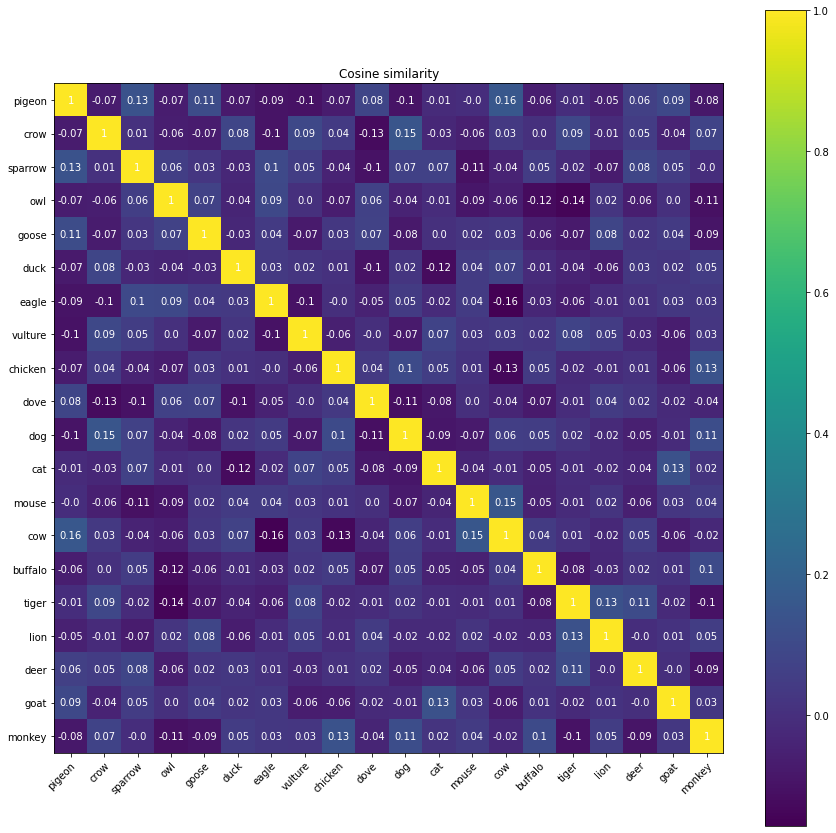

In [212]:
H = np.array(outer)  # added some commas and array creation code
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(111)
ax.set_title('Cosine similarity')
ax.set_xticks(np.arange(len(birds+animals)), labels=birds+animals)
ax.set_yticks(np.arange(len(birds+animals)), labels=birds+animals)
plt.imshow(H)
ax.set_aspect('equal')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(birds+animals)):
    for j in range(len(birds+animals)):
        text = ax.text(j, i, round(outer[i][j], 2),
                       ha="center", va="center", color="w")

plt.colorbar(orientation='vertical')
plt.show()

Creating clusters from animals + birds embeddings:

In [203]:
words_embedds = []
for words in birds + animals:
        w_id = skipg.word_index[words]
        words_embedds.append(skipg.w1[w_id])

cluster = KMeans(n_clusters = 2)
cluster_labels = cluster.fit_predict(words_embedds)

In [204]:
cluster_labels

array([1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0],
      dtype=int32)

In [198]:
cluster_labels = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [206]:
silhouette_score(words_embedds, cluster_labels), davies_bouldin_score(words_embedds, cluster_labels)

(0.02085846840794372, 3.3213319286969103)

In [54]:
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format("/Users/vedantsingh/Downloads/archive/GoogleNews-vectors-negative300.bin",binary=True)

In [200]:
words_embedds = []
for words in birds + animals:
        words_embedds.append(word_vectors.get_vector(words))

cluster = KMeans(n_clusters = 2)
cluster_labels = cluster.fit_predict(words_embedds)

In [201]:
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
      dtype=int32)

In [209]:
outer = []
for X in birds+animals:
    inner = []
    for Y in birds + animals:
        inner.append(1 - spatial.distance.cosine(word_vectors.get_vector(X), word_vectors.get_vector(Y)))
    outer.append(inner)


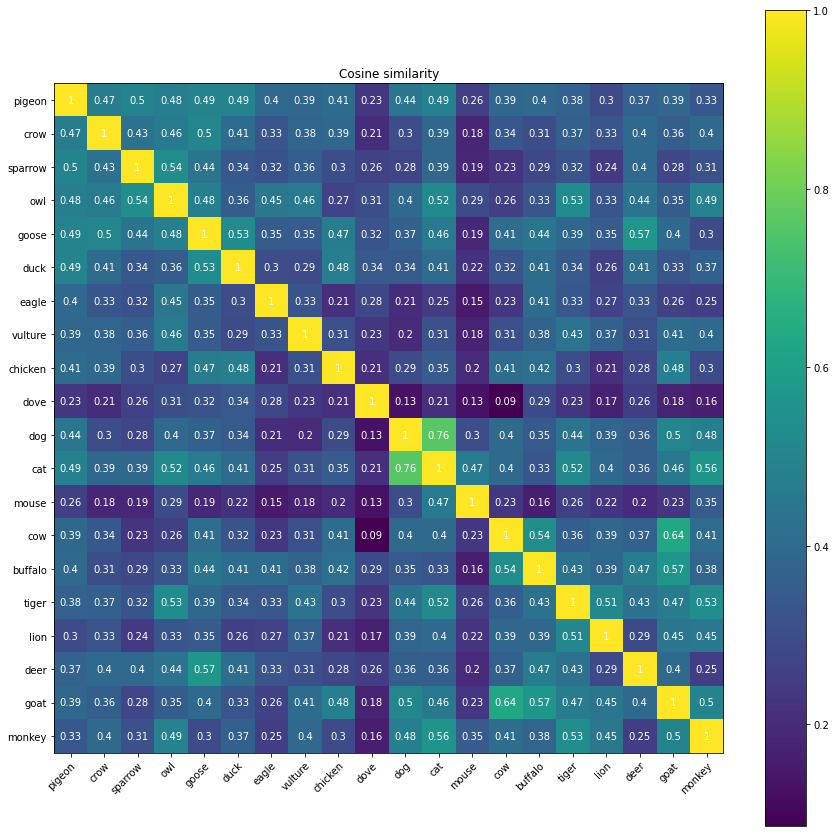

In [210]:
H = np.array(outer)  # added some commas and array creation code
fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(111)
ax.set_title('Cosine similarity')
ax.set_xticks(np.arange(len(birds+animals)), labels=birds+animals)
ax.set_yticks(np.arange(len(birds+animals)), labels=birds+animals)
plt.imshow(H)
ax.set_aspect('equal')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(birds+animals)):
    for j in range(len(birds+animals)):
        text = ax.text(j, i, round(outer[i][j], 2),
                       ha="center", va="center", color="w")

plt.colorbar(orientation='vertical')
plt.show()